# 2. A Closer Inspection to the Gravity Example
Sunday, November 4th, 2018<br>
Monday, November 5th, 2018 <br>
Felicia Nurindrawati 

In [4]:
import numpy as np
import matplotlib.pyplot as plt

#This one contains all the main packages you need from SimPEG. 
from SimPEG import Mesh, Utils, Maps, Regularization, DataMisfit, Optimization, InvProblem, Directives, Inversion, PF

Now that I went through the Linear Gravity Inversion Example in the previous chapter, let's go through which package did we actually use and what it actually does 

## 1. Creating our Mesh

We used the **Discretize.Mesh** library to create our mesh. For the source code, see the following link: https://github.com/simpeg/discretize/tree/master/discretize 

**TensorMesh()**

We first initialize how we discretize our mesh in the three axis: hx, hy, and hz and combine them together with: <br>
``` python
mesh = Mesh.TensorMesh([hx, hy, hz], 'CCC')
```

According to the source code in github, the **TensorMesh** class does the following:<br>

*<center>"TensorMesh is a mesh class that deals with tensor product meshes" </center>*<br>
The function accepts 'h', which is a width vector that lets you create these meshes. There are several ways to create these tensorMesh:<br><br>
**a. Using Array of Tuples**: <br>
This is what we used for the Gravity Example. This will accept the width vector 'h' as non-constant and changes as we go through each element in that vector. For example, if we have something like this: <br>
<center>$h = [(10,5,-1.3), (5, 20), (10,5,1.3)] $</center> <br>
That means in the this axis, you will be having 5+20+5 lines (second element for each tuple). The first tuple, (10,5,-1.3), means that each line in the mesh, you will have the following distance between lines for every iteration. <br>
<center>$-(10*1.3^1$),$-(10*1.3^2$), ..., $-(10*1.3^5$)  </center><br>
The second tuple will have 20 lines with a constant distance of 5. So you should be getting something like this:<br>
<center>$5*1^1,5*1^2, ..., 5*1^{20}$  </center><br>
Lastly, the third tuple would be the same as the first one. But because the exponential element is not negative, we should be seeing something like a "flipped version of the first tuple: <br>
<center>$10*1.3^1$,$10*1.3^2$, ..., $10*1.3^5$ </center><br>
Combining all of those together, we should get something like this:<br>

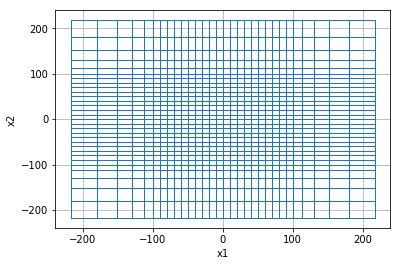

In [37]:
h = [(10,5,-1.3), (10,20), (10,5,1.3)]
mesh = Mesh.TensorMesh([h,h], 'CC')
mesh.plotGrid() #plotting the grid

**b. Quick TensorMesh**<br>

This is a quick way of creating a 3D unit cube. Inputting a [a,b,c] array will breate a mesh on a axbxc unit cube. For example, if you have something like: <br>
``` python 
mesh = Mesh.TensorMesh([10,12,15])
```
**Note**: Remember! In Mesh, count the *cubes*, not the *lines*!

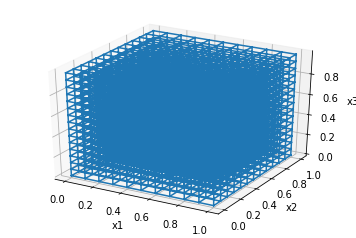

In [38]:
h = [10,12,15]
mesh = Mesh.TensorMesh(h)
mesh.plotGrid()

There is also input that you would put in the end of the function as the following:<br>
```python
mesh = Mesh.TensorMesh([h1,h2], 'CC')
```
The *'CC'* means **'Cell-Centered Grid'**. That means everything is centered at 0. This is the default state of the input.<br><br>
Another option for this is 'N', which means **Nodal Grid**, so everything would be to the left of zero. For example: <br>
    

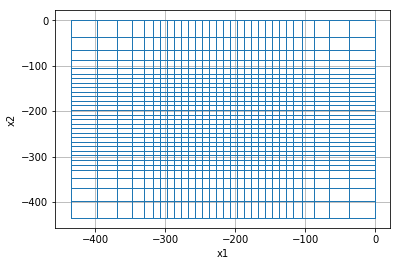

In [66]:
h = [(10,5,-1.3), (10,20), (10,5,1.3)]
mesh = Mesh.TensorMesh([h,h], 'NN')
mesh.plotGrid() #plotting the grid

Keep in mind that the number of 'C's and 'N's depends on the dimension of our mesh. If we're dealing with a 3D grid, that means it should be *'CCC'* and *'NNN'*, etc. <br>


**Inside the 'Mesh' Object** <br>

**Parameters:**
When you print your mesh, you will get something like this:<br>


In [68]:
print(mesh)

  ---- 2-D TensorMesh ----  
   x0: -435.12
   y0: -435.12
  nCx: 30
  nCy: 30
   hx: 37.13,  28.56,  21.97,  16.90,  13.00,  20*10.00,  13.00,  16.90,  21.97,  28.56,  37.13,
   hy: 37.13,  28.56,  21.97,  16.90,  13.00,  20*10.00,  13.00,  16.90,  21.97,  28.56,  37.13,


Now what does that mean? Each of the parameters in the mesh object means the following: <br>

- **x0**: First element location in our x-axis
- **nCx**: Number of elements in our x-axis
- **hx**: Each length for our cube in our mesh in the x-axis
- **vectorNx**: Vector of each location of the lines for our mesh in the x-axis (has N+1 elements, where N is the number of cubes in our grid in the x-axis)
- **vectorCCx**: Vector of each cell-centered location of the cube in the x-axis
- **gridCC**: Cell centered grid location (has NxN elements)
- **gridN**: Nodal grid location (has N+1 x N+1 elements)<br>


(The above 'x's can be replaced by 'y' and 'z' to get the components in the respective axis)<br>
There are other parameters such as **gridFx**(face staggered grid), **gridEx**(Edge Staggered grid), but I have no idea what that means

**Methods:** There's a lot of methods in the Mesh object, You can see it in the source code. More important parts of this include: <br>

- **isInside(pts)**: Determines if a certain set of points are inside the mesh
- **getInterpolationMat(loc, locType)**: Interpolate matrix to location in loc. Returns the matrix that was interpolated. locType are those 'N', 'CC', etc.
- **TensorMesh**: This is what we used in the example. Deals with tensor product of the meshes, combine meshes into grids.


There's also 'geometries' property that constructs these arrays, and tests if the geometry is correct for the grid. 

Fiuh, that's a lot just for the mesh. Now let's move on to building our topography:

## 2. Topography

Like a regular gravity survey, we should be dealing with different elevations and such. As we can see in the previous example, we can create a synthetic topography by first creating a 2D meshgrid from VectorNx and VectorNy as the following: <br>
```python
[xx, yy] = np.meshgrid(mesh.vectorNx, mesh.vectorNy)
```
Then we use some sort of equation to determine what our z is going to be like:
$$zz = -exp({\frac{x^2 + y^2}{75^2}}) + 53.64 $$
With known zz, we can then build the topography as such: <br>
```python
topo = np.c_[Utils.mkvc(xx), Utils.mkvc(yy), Utils.mkvc(zz)]
```


Hold on! That's another package! We were using a library from SimPEG called **Utils**. Now Utilities has a lot of methods and such, but we'll be focusing on the use of this for building topography. 

**Utils.mkvc()**<br>
Like the TensorMesh method, this is located in the discretize library. Specifically in: Discretize/Utils/Matutils. Follow this link for the sourcecode:<br>
https://github.com/simpeg/discretize/blob/master/discretize/utils/matutils.py<br>
What does Utils.mkvc do? <br>
If it isn't as obvious, mkvc stands for MaKeVeCtor, so like its name, it creates a vector with the number of dimension specified.

For example, you have xx, which is a 26x26 vector with the elements of the cube location in the x axis. Utils.mkvc(xx) will create a vector of 26x26 containing each element in xx. <br>
Concatenating all three axes with np.c_, you will get a (26x26, 3) matrix which represents our topography in 3D 

In [85]:
[xx, yy] = np.meshgrid(mesh.vectorNx, mesh.vectorNy)
print(xx.shape)
print(Utils.mkvc(xx).shape)


(26, 26)
(676,)


Most of the stuff we did with gravity was contained in the *PF.Gravity* module. We can find the documentation of that module from this link: <br>
https://github.com/simpeg/simpeg/blob/master/SimPEG/PF/Gravity.py

**Activate Cells**<br>
**Utils.surface2ind_topo**
This is to create an active cell from the topo. I have no idea what they mean by active cell.<br>
Going through the code, we defined the active cells 'actv' as such: <br>
```python
actv = Utils.surface2ind_topo(mesh, topo, 'N')
actv = np.asarray([inds for inds, elem in enumerate(actv,1) if elem], dtype=int)-1

```
Now what does that mean? let's find out!
For the source code, it is located in *SimPEG/Utils/modelutils*. Follow this link for the source code:<br>https://github.com/simpeg/simpeg/blob/master/SimPEG/Utils/modelutils.py

**Utils.surface2ind_topo(mesh, topo, 'N')**<br>
From the above line of code, we can tell that the method accepts the mesh that we created using *TensorMesh*, the topography [xx, yy, zz] that we have created by concatenating the axis vectors made using *Utils.mkvc()* and a gridLoc argument 'N' which means we will be using 'nodes' instead of 'cell centered'. This returns an index vector for active cells on the mesh below the topography. <br>
Therefore, the active cells that we meant here are the cells that are below the topography, since we don't really need to activate does above the ground.<br>
However, if we print what *actv* is, we will get something an array of just: <br>
```python
    [True  True  True  ...  False   False  False]
```
Which makes sense because *.surface2ind_topo* only returns true/false if a cell is below the topography or not. We need to turn this to something readable for the next steps. That's why we have this: <br>
```python 

actv = np.asarray([inds for inds, elem in enumerate(actv,1) if elem], dtype=int)-1
```
This gives an index from 0 to M-1, where M is the number of active cells. For example, before turning this into an array, we have **11,250** elements cells in our grid. After deleting the inactive cells through the for loop above, we get only **10,085** active cells.<br><br>

BUT WAIT! There's more to this! You need to create a map that goes from the full space that we originally have to the reduced space from the active cells that we have now! What's that? Maps you say? Well now we need to explore a new package called **Maps**.

**Maps.InjectActiveCells(mesh, actv, -100)** <br>
The code that we used for this is: <br>
```python
actvMap = Maps.InjectActiveCells(mesh, actv, -100)
```
You can get the source code in the above line from *SimPEG/Maps*, or follow this link:  https://github.com/simpeg/simpeg/blob/master/SimPEG/Maps.py


*Hmmmm I can't really find a good-enough documentation for this method. Though I'm assuming that it injects the active cells we found to our mesh, so we don't need to deal with those inactive cells everytime we call mesh*

## 3. Creating a Survey
Okay, now we're done building our grid and topography. Now let's get on with the survey setup!<br>
First we create the observation points. There's really nothing new about this. It's just like building the mesh and topography but this time you have *rxloc* instead of *topo*.
```python
#Array of observation points
xr = np.linspace(-30.,30.,20)
yr = np.linspace(-30.,30.,20)
X,Y = np.meshgrid(xr,yr)

#Survey is 5m above topo
Z = -np.exp((X**2 + Y**2) / 75**2) + mesh.vectorNz[-1] + 5 
rxloc = np.c_[Utils.mkvc(X.T), Utils.mkvc(Y.T), Utils.mkvc(Z.T)]

```

Now we finally use the **PF** package to deal with gravity problems (and other problems as well). The next line of code from the example is the following: <br>
```python
rxLoc = PF.BaseGrav.RxObs(rxloc)
srcField = PF.BaseGrav.SrcField([rxLoc]) 
survey = PF.BaseGrav.LinearSurvey(srcField)

```

The BaseGrav method is located in SimPEG/PF/BaseGrav. Follow the link to the sourcecode: https://github.com/simpeg/simpeg/blob/master/SimPEG/PF/BaseGrav.py

**PF.BaseGrav**<br>

The library is used to create a gravity survey and has a few classes, including: <br>
- **PF.BaseGrav.RxObs(Survey.BaseRx):**<br>
In this step, we used the *RxObs* class, which accepts the array that contains the survey receivers in 3D, and then turns it into a BaseGrav.RxObs object. You can access the location with [object].locs, which contains a (NxN,3) matrix containing the receiver locations. The class also makes sure that the location *must* be in 3D space. <br>
- **SrcField(Survey.BaseSrc):**<br>
According to the source code, this defines the inducing field. Since this is a gravity survey, the parameter for the inducing field (Amp, Incl, Decl) is set to None. Like RxObs, it accepts rxLoc that we have made in the previous line(array) and returns a PF.BaseGrav object.  
- **LinearSurvey(Survey.BaseSurvey)**:<br>
For linear survey, we use a base Magnetic survey in this case (because gravity and magnetics survey are interchangable). The class accepts SrcField that we have defined in the previous line. Seems like it just creates a survey object based on the input. It also has a projectFields method, but seems like this is only relevant for Magnetics survey.<br>
Edit: It simulate the electrical potential in 3D space, and then project these electrical potential into the receiver location, based on the mesh
- **BaseGravMap(Maps.IdentityMap)**<br>
Hasn't been used yet


## 4. Creating a Model
First, we need to initialize the values in our grid to zero. Then we can set it up as the model we would like by adding values to the dimension we want (two cubes near the surface). Luckily, we can easily do this with our mesh object since we can access the number of elements in x, y, z axis easily in our mesh. 
```python 
#Find the middle element in our mesh so we can put our model object around it
midx = int(mesh.nCx/2)
midy = int(mesh.nCy/2)

#Create the model (and set the delta rho value too)
model = np.zeros((mesh.nCx, mesh.nCy,mesh.nCz))
model[(midx-5):(midx-1), (midy-2):(midy+2), -10:-6] = 0.75
model[(midx+1):(midx+5), (midy-2):(midy+2), -10:-6] = -0.75
```

Next part is like the previous step where we set up the **active cells** and its map.<br>
```python
model = Utils.mkvc(model)
model = model[actv] #model only contains active cell 
actvMap = Maps.InjectActiveCells(mesh, actv, -100)
idenMap = Maps.IdentityMap(nP=nC) #nP is the number of parameters the mapping accept

```
Now *idenMap* contains the density model that we want. In other words, creating a model will be the same as creating the mesh, only this time we set some boundaries and assign some cells with values.

## 5. Forward Modelling
**PF.Gravity.GravityIntegral()**<br>
For the forward modelling, we will be using the **PF.Gravity** library (src: https://github.com/simpeg/simpeg/blob/master/SimPEG/PF/Gravity.py). <br>
The following is used to initialize our gravity forward modelling problem:<br>
```python
prob = PF.Gravity.GravityIntegral(mesh, rhoMap=idenMap, actInd=actv)

#MAKE SURE YOU ONLY RUN THIS ONCE!
#It creates error if you run this cell more than once
#It gets confused because you try to pair something that's already paired
survey.pair(prob) 
d = prob.fields(model)
```
The line of code above accepts our mesh grid, our density map (idenMap), and also set the active index as the *actv* vector that we had build (it just stores the inputs into the object). The class has a few methods that we will talk about later on. <br><br>


**Getting to know your 'Prob'(lem)** <br>
**survey.pair(prob) **<br>
Before we can move on to do the forward modelling operator, we need to pair the survey with the problem/model we have set up. This is apparent in the *survey.pair(prob)* line. In the source code, it should be in SimPEG/Survey. It binds a problem object to the Survey using pointers. You can also unbind the survey and problem using the *survey.unpair*. <br>
With the pairing done, you can then access some of the 
parameters that will greatly be useful for our forward problem, such as getting the G matrix. This, and other paramters, can be access using<br>
```python
G = prob.G #get G matrix, found with Intrgl_Fwr_Op Function
m = prob.model #get the model
IdenMap = prob.rhoMap #get the density map 
rho = prob.rho #density values
rhoD = prob.rhoDeriv #tuple of index pairs and value

```


Binding the survey will greatly help in the next step. <br><br>



**Forward Operation** <br>
**prob.field(model) **
An important method for this object is the *fields* method, which will let us do the forward operation by calling the *fwr_op* method. This method calls other methods defined in the library and calculates data based on G and m. This includes caluclating the tensor (Tx, Ty, Tz) in *get_T_mat* method, and also accounts for activating the cells. ***In depth analysis of this will be done if needed. For now, refer to the following link for the source code:***
https://github.com/simpeg/simpeg/blob/master/SimPEG/PF/Gravity.py<br><br>
We know this common forward operation such as the following: <br>
$$d = Gm $$
In our code, we can type it using the *probs.fields(model)* method.This gives us a data vector of size NxN(20x20).




## 6. Adding Noise and Finding Weights

Adding noise to your data is nothing abnormal, and so is finding the weight of the data (Wd). Just use numpy and you're done. <br>
```python 
data = d+np.random.randn(len(d))*1e-3 
wd = np.ones(len(data))*1e-3 

```
Now that we have our noisy data and weights, we can store that in our survey object: <br>

```python
survey.dobs = data #observed data with noise
survey.std = wd #standard deviation on the data
survey.mtrue = model #true model in the survey

```

Forward modelling can have errors accounted to it, so let's find the weights from our G (Wr): <br>
```python
rxloc = survey.srcField.rxList[0].locs #this is just the location of our receivers
wr = np.sum(prob.G**2, axis=0)**0.5
wr = wr/np.max(wr) 
```

We see that from the equation above that we are using the integral of $\sqrt(G^2)$, normalized with max G. **(???)**

## 7. Regularization

**Regularization.Sparse() **

The equation that we used for regularization is: <br>
 $$R(m) = \frac{1}{2}\mathbf{(m-m_\text{ref})^\top W^\top R^\top R
 |          W(m-m_\text{ref})}$$

This equation can be accessed through the *Regularization.Sparse()* method in the **Regularization** package. Let's look at it up close in this source code: https://github.com/simpeg/simpeg/blob/master/SimPEG/Regularization.py <br>

```python 
reg = Regularization.Sparse(mesh, indActive=actv, mapping=idenMap)
reg.cell_weights = wr
reg.norms = np.c_[1,0,0,0] #sparse regularization
```

The first line of code initialize the Regularization object by storing our mesh, active cells, and density mapping (*idenMap*) in it. The next line of code, we can see that the *cell_weights* is initialized with Wr and the *norms* is also initialized to a certain array. 
**cell_weights** is the regularization weights applied to the center of the cells, that's why it's set to Wr. Meanwhile **norms** refer to the norms used to create the sparse regularization. The default value is **np.c_[2.,2.,2.,2.,]**. There are other parameters that go to this method, but for now let's just see the ones we actually used in this problem. 

## 8. Finding Misfit

We used L2 norm for the misfit function, such as this equation: <br>
$$ \mu_\text{data} = {1\over 2}\left|
 |      \mathbf{W}_d (\mathbf{d}_\text{pred} -
 |      \mathbf{d}_\text{obs}) \right|_2^2$$
 Where $\mu_{data}$ is misfit for the data side.<br>
 We can access this equation in the **DataMisfit** library (src: https://github.com/simpeg/simpeg/blob/master/SimPEG/DataMisfit.py) <br>
 

```python
dmis = DataMisfit.l2_DataMisfit(survey)
dmis.W = Utils.sdiag(1/wd)
```

**DataMisfit.l2_DataMisfit(survey)**<br>
There are a few parameters in this class, like std (standard deviation) and eps (floor?), and also W (weight) and deriv (first derivative). The method accepts our survey object and spits out a misfit object. In the above code, we can also set the weight in the data misfit object with a diagonal vector of $\frac{1}{W_d}$<br>
**Question: How do you access dmis?**

## 9. It's time for Inversio-

## 9. Optimization

**Optimization.ProjectedGNCG() **

Right. There's a whole library on Optimization. Here's the snippet of code that we used for it: <br>


```python
opt = Optimization.ProjectedGNCG(maxIter=100, 
                                 lower=-1., 
                                 upper=1.,
                                 maxIterLS=20, 
                                 maxIterCG=10,    
                                 tolCG=1e-3) 
```
Whoaaa what are thooooose???<br>
Well apparently we can see what this is from the SimPEG.OPtimization library located here: https://github.com/simpeg/simpeg/blob/master/SimPEG/Optimization.py <br>

**Minimize** <br>
The first thing that the method does is to call *Minimize*, which "minimizes the general class for derivative based optimization" (General Optimization Algorithm). We can initizalize the parameters that go through this method, including: <br>

- **maxIter**: Maximum number of iterations 
- **lower**: lower bound of our pertubation (?) (in ProjectedGNCGG)
- **upper**: upper bound of our pertubation (?) (in ProjectedGNCGG)
- **maxIterLS**: Maximum number of iteration for line-search
- **maxIterCG**: Maximum number of iteration in Projected Gradient
- **tolCG**: (I have no idea what this is but it's in the ProjectedGradient method)

## 10. Inversion Problem

**InvProblem.BaseInvProblem(dmis, reg, opt)**

Now to actually do something about the inversion. Let's recap for a bit. We have now found the data misfit function **dmis**, regularization **reg**, and optimization function **opt**. What's next is to input all of those into our Inverse problem object using the **InvProblem** library. 
```python 
invProb = InvProblem.BaseInvProblem(dmis, reg, opt)
```
Since we already have the three inputs, it's easier for us to build our inversion problem!<br> <br>



Let's look at the documentation for InvProblem (src: https://github.com/simpeg/simpeg/blob/master/SimPEG/InvProblem.py) <br>
There are just one classe in the InvProblem package: <br>
- **BaseInvProblem()**: This accepts the parameters for the InvProblem object. These parameters include *beta*, *dmisfit*, *reg*, *opt*. From the documentation, it seems that it calculates *phi_d* and *phi_m* from the inputs, and also contains *model*. However, since this line of code only stores the inputs, if we print *invProb.model*, you will get "None" since no computations have been done. 

**Directives**<br>
```python
betaest = Directives.BetaEstimate_ByEig()

IRLS = Directives.Update_IRLS(f_min_change=1e-4, maxIRLSiter=30, coolEpsFact = 1.5, beta_tol=1e-1, )

saveDict = Directives.SaveOutputEveryIteration(save_txt=False)
update_Jacobi = Directives.UpdatePreconditioner() 

```
I'm not really sure what it does, but based on the sourcecode, it might be a package to determine which direction we should use to find Beta in our inversion? (src:https://github.com/simpeg/simpeg/blob/master/SimPEG/Directives.py) <br>

The Directives package has a few class in it. The one we used in the code is: <br>
- **BetaEstimate_byEig()**<br>
The class first initializes beta by comparing the estimated eigenvalues of JtJ(Jacobian) and WtW using the power method:<br>

$$ \mathbf{x_1 = A x_0} $$
Then find the largest eigenvalue:<br>


$$\lambda_0 = \frac{\mathbf{x^{\top A x}}}{\mathbf{x^{\top x}}} $$

$\beta_0$ estimate will use the ratio of the quotient:<br>


$$\beta_0 = \gamma \frac{\mathbf{x^\top J^ \top J x}}{\mathbf{x^ \top W^ \top W x}} $$
 
This method returns $\beta_0 $<br>
The code representation of the above mathematical equation can be seen here: <br>

```python
for dmis, reg in zip(self.dmisfit.objfcts, self.reg.objfcts):
    if len(self.dmisfit.objfcts) > 1:
        t += x0.dot(dmis.deriv2(m, x0, f=f[i_count]))
        else:
            t += x0.dot(dmis.deriv2(m, x0, f=f))
        b += x0.dot(reg.deriv2(m, v=x0))
        i_count += 1
self.beta0 = self.beta0_ratio*(t/b)
self.invProb.beta = self.beta0
```
We can see that the for loop above calculates beta using the ratio that they obtained from the derivative of data misfit and model(?).<br>
The next line of code finds the Itteratively Reweighted Least Squares (IRLS) using the Directives package. <br>

- **UpdateIRLS()**<br>
There are a lot of parameters in this method. From the line of code we used in the example, we input the following parameter: <br>
    - *f_min_change = 1e-4*:<br>
Minimum function change. If the function change is not bigger than the value, then it will not do the iteration. 
    - *maxIRLSiter = 30*: <br>
Maximum number of IRLS cycle. Will exit the function if exceeds this number.  
    - *coolEpsFact = 1.5*:<br> 
This value is what you divide to regularization eps(?) to get Eps_p and Eps_q (???). Might be the cooling factor. 
    - *beta_tol = 1e-1*:<br>
Beta tolerance. Used to check if misfit is within tolerance, if not we scale beta. <br>

- **SaveEveryIteration()**<br>
For this one, our input is that save_txt=False, which means we don't need to save every output into a text file (Though changing this to True didn't really change anything)<br>

- **UpdatePredictioner()**<br>
According to the documentation, it creates a Jacobi preconditioner for the linear problem. The following are the code representation of the mathematical functions for this method's for loop over the problem and misfit object: <br>
```python 
JtJdiag += np.sum(np.power((dmisfit.W*prob.getJ(m)), 2), axis=0)
```

Other classes in this package include: 
- **TargetMisfit()**
- **InversionDerictive()**
- **DirectiveList()**
- **BetaSchedule()**
- **TargetMisfit()**
- **Update_Wj()**
- **UpdateSensitivityWeights()**




Following the lines of code that deal with the directives, we get to the line of code that actually does the inversion process. The code is the following: <br>
```python 
inv = Inversion.BaseInversion(invProb, directiveList=[IRLS, betaest, update_Jacobi, saveDict])
```
This is using the Inversion.BaseInversion package and accepts the invProb object, and a directive list containing the objects we obtained from the Directives package. Follow the link for the source code: https://github.com/simpeg/simpeg/blob/master/SimPEG/Inversion.py <br><br>
**Inversion.BaseInversion() **

The Inversion library only contains one class, which is BaseInversion. It seem to accept the objects from the input and store them in our Inversion problem. This class also has one a method called **run(m0)** which will be used to do our inversion operation. <br><br>

**run(m0) **<br>

Our inversion operator uses the following lines of code:<br>
```python
m0 = np.ones(nC)*1e-4 #starting model
mrec = inv.run(m0) 
```
With the the initial model as the input, the line of code performs the inversion operator with the *inv* object that we have build from the previous steps to get our inverted model. Thus, *mrec* is a vector that contains our recovered model.
<br><br>

**Plotting**<br>
To plot our recovered model, all we have to do is multiply the recovered model (*mrec*) with our Activated Map (*actvMap*). Furthermore, we can also accessthe L2 model by by multiplying said model stored in the inverse problem object (*invProb.l2model*) with the Activated Map too. <br>
Plotting the actual model isn't really contained in the "SimPEG" library so I'll refrain from talking about it in this guide. 


![image](https://i.kym-cdn.com/photos/images/original/001/026/838/cc4.jpeg)